# Data Preparation

Data loading and import statements:

In [1]:
from pandas import read_csv, Series, DataFrame, concat, unique
from ds_charts import get_variable_types, choose_grid, HEIGHT, multiple_bar_chart, multiple_line_chart, bar_chart

from pandas.plotting import register_matplotlib_converters
from matplotlib.pyplot import figure, savefig, show, subplots, Axes, title, tight_layout
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from numpy import log
from seaborn import distplot, heatmap
from scipy.stats import norm, expon, lognorm

import numpy as np
import matplotlib.pyplot as plt
import ds_charts as ds

In [2]:
filename = 'data/raw/NYC_collisions_tabular.csv'
filetag = 'NYC_collisions_tabular'
raw_dataset = read_csv(filename)

Auxiliary Functions:

1. **Convert_date_to_int**: Converte the date in the data set (dd/mm/yyyy) to an integer between 0 and 365
2. **dummify**: Dummify all symbolic variables

In [3]:
def convert_date_to_int(date):
  aux = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
  month = int(date[3:5])
  day = int(date[:2])
  result = 0
  for i in range(month):
    result += aux[i]

  return result + day

def dummify(df, vars_to_dummify):
  other_vars = [c for c in df.columns if not c in vars_to_dummify]
  encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=bool)
  X = df[vars_to_dummify]
  encoder.fit(X)
  new_vars = encoder.get_feature_names(vars_to_dummify)
  trans_X = encoder.transform(X)
  dummy = DataFrame(trans_X, columns=new_vars, index=X.index)
  dummy = dummy.convert_dtypes(convert_boolean=True)

  final_df = concat([df[other_vars], dummy], axis=1)
  return final_df

def dummify_input_accord(dataset, variable, keywords):
  
  return dataset

### Missing value imputation and dummifcation

remove redundant variables, i.e ID variables:

In [4]:
collums_to_drop = ['VEHICLE_ID', 'PERSON_ID', 'UNIQUE_ID', 'COLLISION_ID']
data = raw_dataset.drop(columns=collums_to_drop, inplace=False)

convert dates to a single integer:

In [5]:
#convert crash time to an integer between 0 and 23
data['CRASH_TIME'] = data['CRASH_TIME'].apply(lambda x: int(x[:2]))

#conver crash date to an integer
data['CRASH_DATE'] = data['CRASH_DATE'].apply(convert_date_to_int)

remove outliers from `PERSON_AGE` variable:

In [6]:
data["PERSON_AGE"]=data["PERSON_AGE"].fillna(data["PERSON_AGE"].mean())
data.loc[abs(data['PERSON_AGE'])>100,'PERSON_AGE'] = data['PERSON_AGE'].mean()

fill missing values:

In [7]:
data["CONTRIBUTING_FACTOR_1"]=data["CONTRIBUTING_FACTOR_1"].fillna('Unspecified')
data["CONTRIBUTING_FACTOR_2"]=data["CONTRIBUTING_FACTOR_2"].fillna('Unspecified')
data=data.fillna('Unknown')

#### Scaling:

get variable types:

In [8]:
variable_types = get_variable_types(data)
numeric_vars = variable_types['Numeric']
symbolic_vars = variable_types['Symbolic']
boolean_vars = variable_types['Binary']

df_nr = data[numeric_vars]
df_sb = data[symbolic_vars]
df_bool = data[boolean_vars]

scaling with z-score:

In [9]:
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, concat

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=data.index, columns= numeric_vars)
norm_data_zscore = concat([tmp, df_sb,  df_bool], axis=1)

scaling with MinMax:

In [10]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=data.index, columns= numeric_vars)
norm_data_minmax = concat([tmp, df_sb,  df_bool], axis=1)
print(norm_data_minmax.describe())

         CRASH_DATE    CRASH_TIME    PERSON_AGE
count  45669.000000  45669.000000  45669.000000
mean       0.544101      0.584604      0.367815
std        0.273701      0.279745      0.164801
min        0.000000      0.000000      0.000000
25%        0.332288      0.391304      0.250000
50%        0.554859      0.652174      0.340000
75%        0.777429      0.782609      0.480000
max        1.000000      1.000000      1.000000


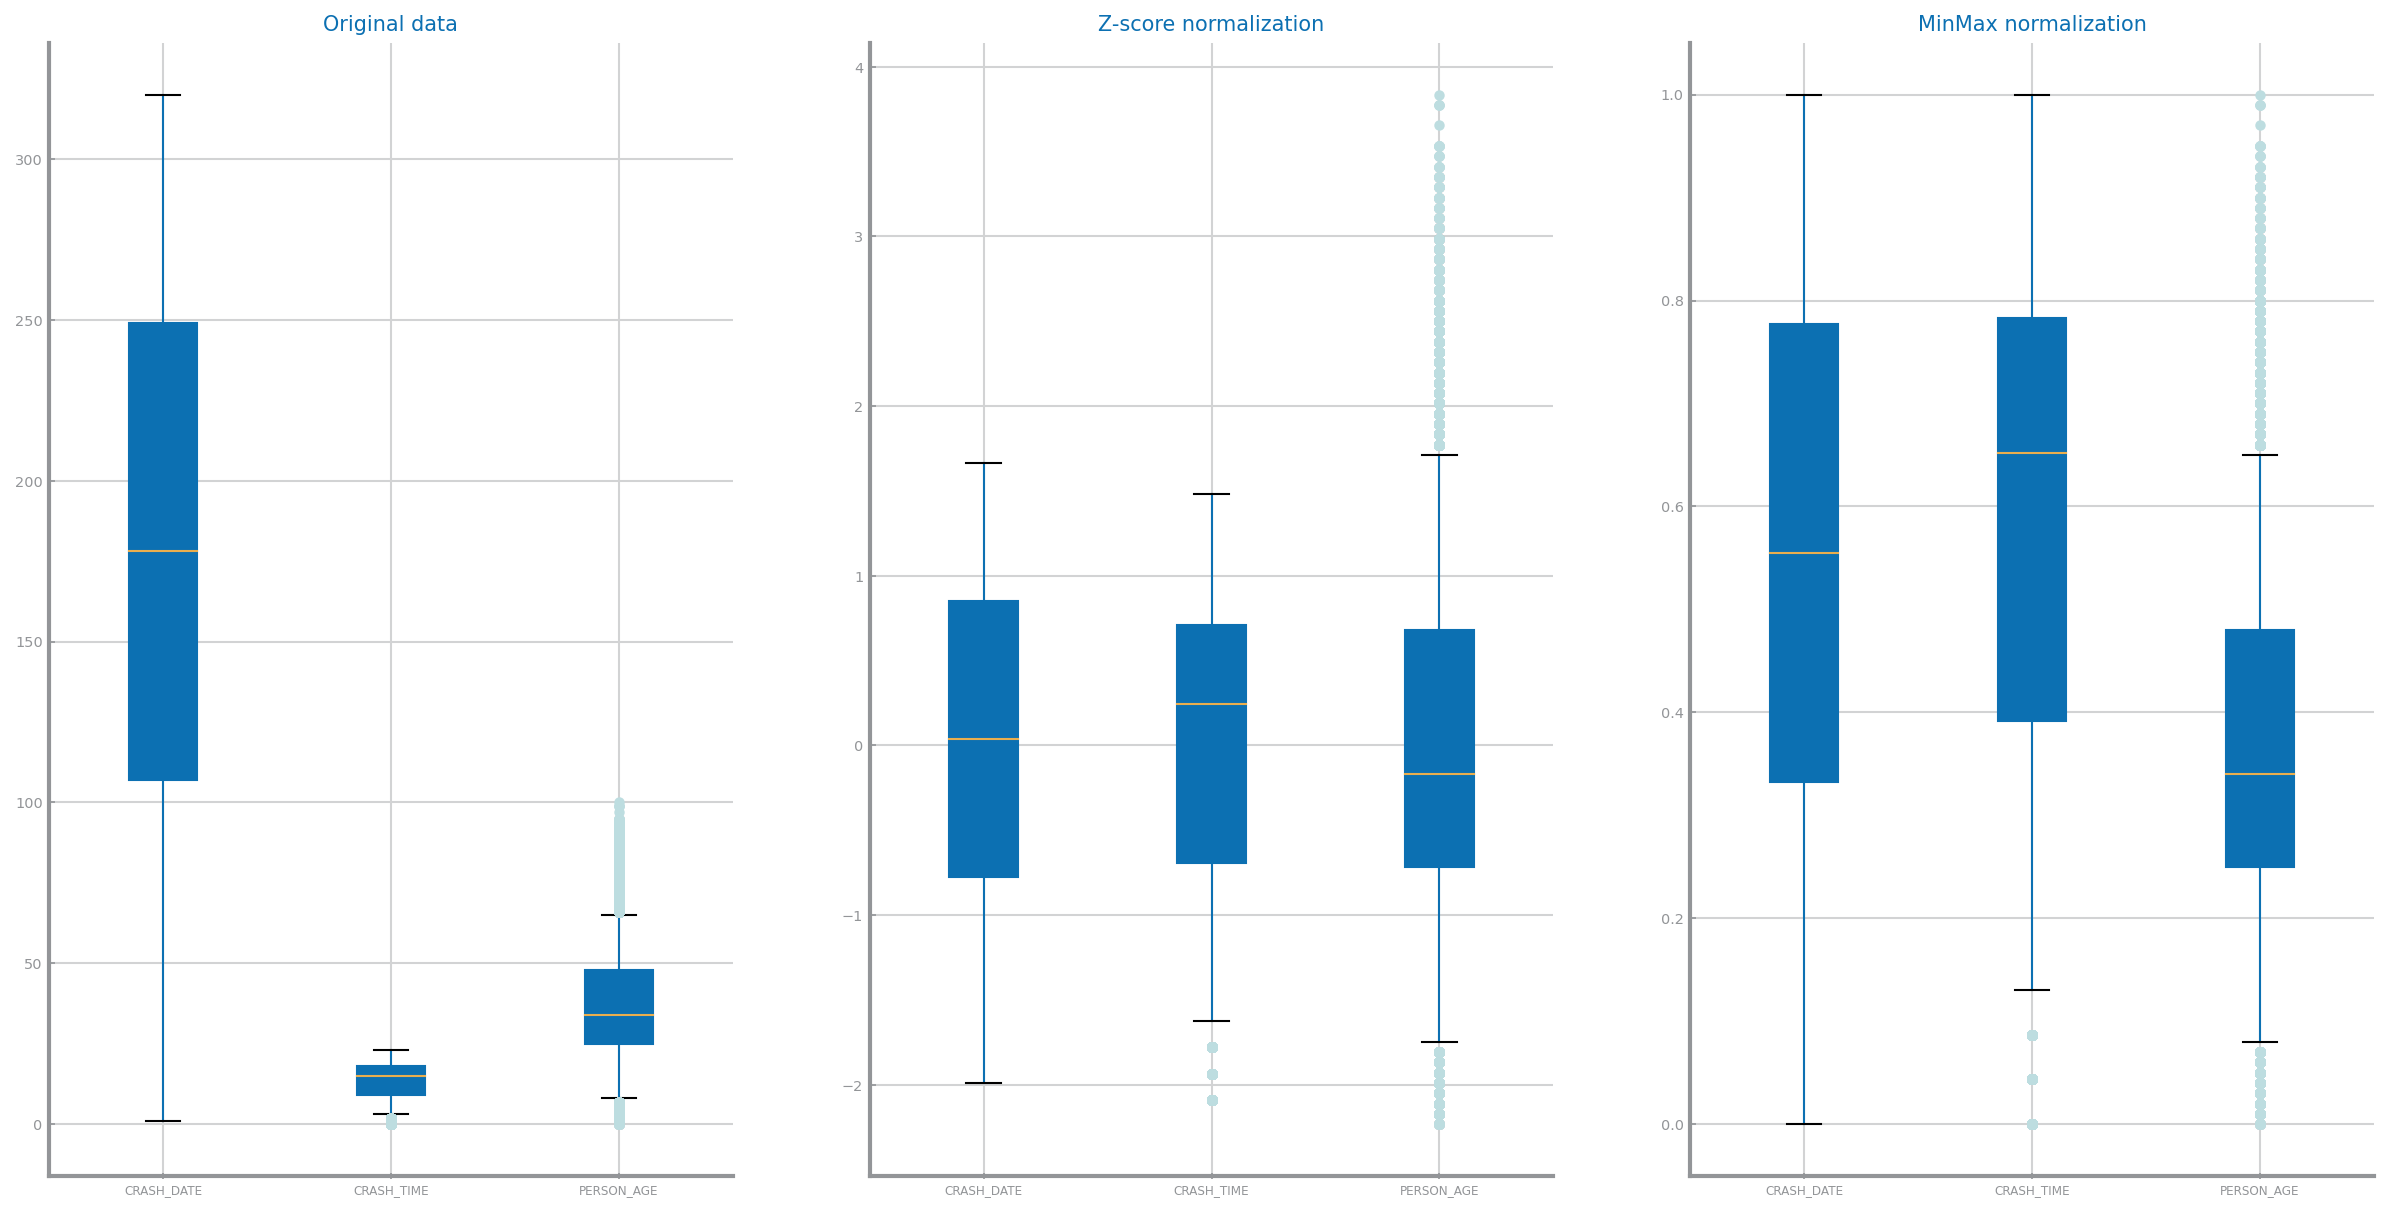

In [11]:
fig, axs = subplots(1, 3, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
data.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2])
show()

#### Apply dummification:

keywords check in certain variables:
  1. Safety Equipment
  2. Contributing factors

In [12]:
# kw = keywords
kw_contributing_factor = [
  'Unspecified',
  'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
  'Driver Inattention/Distraction',
  'Failure to Yield Right-of-Way',
  'Traffic Control Disregarded',
  'Alcohol Involvement',
  'Other Vehicular',
  'View Obstructed/Limited',
  'Cell Phone (hand-Held)',
  'Passing or Lane Usage Improper', 
  'Backing Unsafely',
  'Unsafe Speed',
  'Passing Too Closely',
  'Aggressive Driving/Road Rage',
  'Turning Improperly',
  'Passenger Distraction',
  'Physical Disability',
  'Following Too Closely',
  'Outside Car Distraction',
  'Pavement Slippery',     
  'Drugs (illegal)',
  'Reaction to Uninvolved Vehicle',
  'Driver Inexperience',
  'Fell Asleep',                  
  'Texting',                          
  'Fatigued/Drowsy',                        
  'Animals Action',                          
  'Driverless/Runaway Vehicle',                 
  'Cell Phone (hands-free)',                    
  'Eating or Drinking',                          
  'Illnes',                                   
  'Traffic Control Device Improper/Non-Working',
  'Obstruction/Debris', 
  'Listening/Using Headphones',             
  'Lane Marking Improper/Inadequate',
  'Unsafe Lane Changing',
  'Brakes Defective',
  'Oversized Vehicle',                                         
  'Failure to Keep Right']

kw_safety_equipment = ['Air Bag Deployed', 'Harness', 'Child Restraint', 'Lap Belt', 'Helmet', 'Pads',
                'Stoppers', 'None', 'Unknown', 'Other']

In [13]:
def set1_dummification(dataset):
    for word in kw_contributing_factor:
        dataset['CONTRIBUTING_FACTOR_' + word] = dataset.apply(lambda row : word in row['CONTRIBUTING_FACTOR_1'] or word in row['CONTRIBUTING_FACTOR_2'],axis = 1)

    dataset = dummify_input_accord(dataset, 'CONTRIBUTING_FACTOR_1', kw_contributing_factor)
    dataset = dummify_input_accord(dataset, 'CONTRIBUTING_FACTOR_2', kw_contributing_factor)


    removal_variables = ['SAFETY_EQUIPMENT', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2']
    dataset = dataset.drop(columns=removal_variables, inplace=False)

    variables = ['BODILY_INJURY', 'PERSON_SEX', 'PERSON_TYPE', 'PED_LOCATION',
        'EJECTION', 'COMPLAINT', 'EMOTIONAL_STATUS',
        'POSITION_IN_VEHICLE', 'PED_ROLE', 'PED_ACTION']

    dataset = dummify(dataset, variables)

    return dataset

apply dummification to set with and without scaling:

In [14]:
scaled_dummified_data = set1_dummification(norm_data_zscore)
scaled_dummified_data.to_csv(f'data/transformed/{filetag}_scl_dumm.csv', index=False)
dummified_data = set1_dummification(data)
dummified_data.to_csv(f'data/transformed/{filetag}_dumm.csv', index=False)

## train-test split

dummified data:1

In [15]:
target = 'PERSON_INJURY'
injured = 'Injured'
killed = 'Killed'
values = {'Original': [len(dummified_data[dummified_data[target] == injured]), len(dummified_data[dummified_data[target] == killed])]}

y: np.ndarray = dummified_data.pop(target).values
X: np.ndarray = dummified_data.values
labels: np.ndarray = unique(y)
labels.sort()

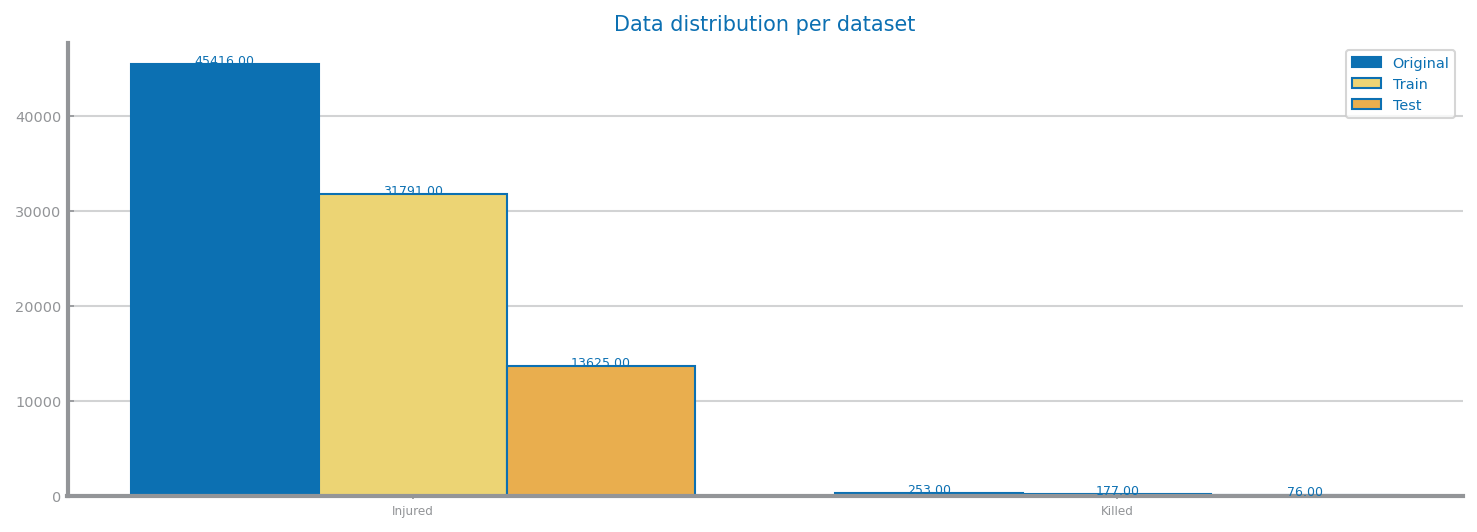

In [16]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = concat([DataFrame(trnX, columns=dummified_data.columns), DataFrame(trnY,columns=[target])], axis=1)
train.to_csv(f'data/transformed/{filetag}_dumm_train.csv', index=False)

test = concat([DataFrame(tstX, columns=dummified_data.columns), DataFrame(tstY,columns=[target])], axis=1)
test.to_csv(f'data/transformed/{filetag}_dumm_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==killed))), len(np.delete(trnY, np.argwhere(trnY==injured)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==killed))), len(np.delete(tstY, np.argwhere(tstY==injured)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([injured, killed], values, title='Data distribution per dataset')
plt.show()

scaled and dummified data:

In [17]:
target = 'PERSON_INJURY'
injured = 'Injured'
killed = 'Killed'
values = {'Original': [len(scaled_dummified_data[scaled_dummified_data[target] == injured]), len(scaled_dummified_data[scaled_dummified_data[target] == killed])]}

y: np.ndarray = scaled_dummified_data.pop(target).values
X: np.ndarray = scaled_dummified_data.values
labels: np.ndarray = unique(y)
labels.sort()

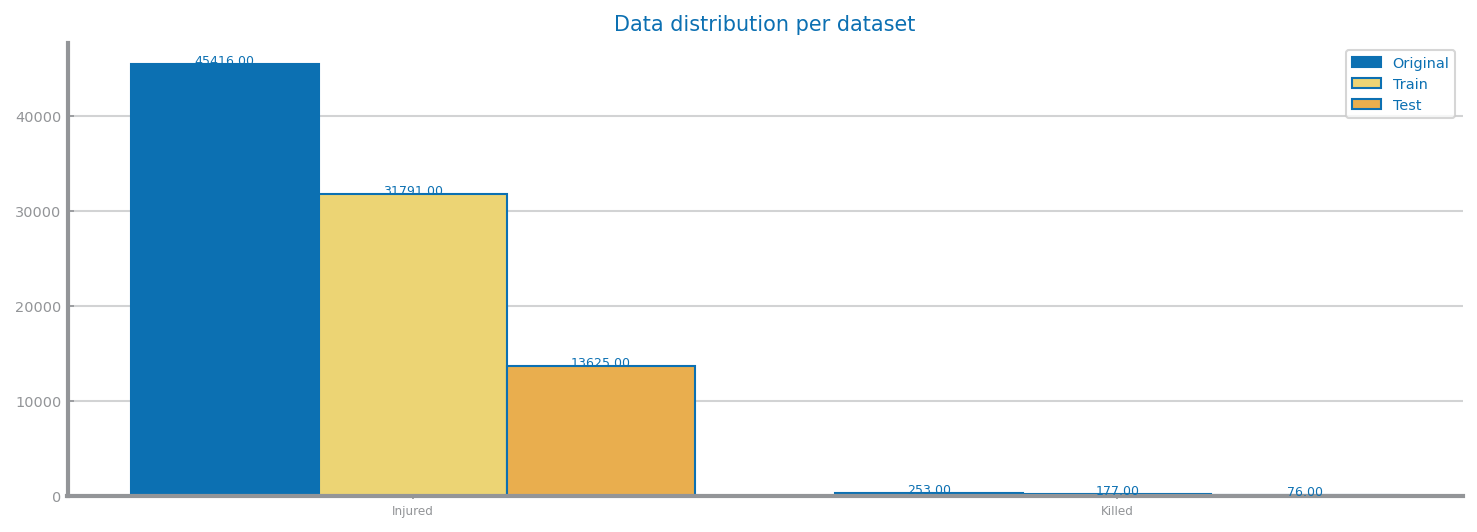

In [18]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = concat([DataFrame(trnX, columns=scaled_dummified_data.columns), DataFrame(trnY,columns=[target])], axis=1)
train.to_csv(f'data/transformed/{filetag}_scl_dumm_train.csv', index=False)

test = concat([DataFrame(tstX, columns=scaled_dummified_data.columns), DataFrame(tstY,columns=[target])], axis=1)
test.to_csv(f'data/transformed/{filetag}_scl_dumm_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==killed))), len(np.delete(trnY, np.argwhere(trnY==injured)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==killed))), len(np.delete(tstY, np.argwhere(tstY==injured)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([injured, killed], values, title='Data distribution per dataset')
plt.show()

## Data Balancing

with scaling and dummification:

Minority class= Killed : 177
Majority class= Injured : 31791
Proportion: 0.01 : 1


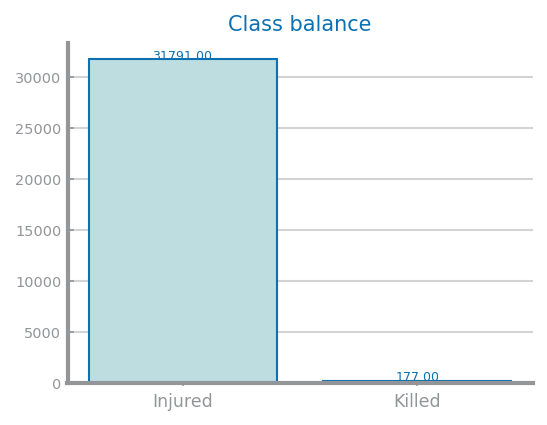

In [19]:
original = read_csv('data/transformed/' + filetag + '_scl_dumm_train.csv', sep=',', decimal='.')
target_count = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()
#ind_positive_class = target_count.index.get_loc(positive_class)
print('Minority class=', positive_class, ':', target_count[positive_class])
print('Majority class=', negative_class, ':', target_count[negative_class])
print('Proportion:', round(target_count[positive_class] / target_count[negative_class], 2), ': 1')
values = {'Original': [target_count[positive_class], target_count[negative_class]]}

figure()
bar_chart(target_count.index, target_count.values, title='Class balance')
show()

In [20]:
df_positives = original[original[target] == positive_class]
df_negatives = original[original[target] == negative_class]

In [21]:
RANDOM_STATE = 42

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = original.pop(target).values
X = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv(f'data/transformed/scl_smote_train.csv', index=False)

smote_target_count = Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count[positive_class], smote_target_count[negative_class]]
print('Minority class=', positive_class, ':', smote_target_count[positive_class])
print('Majority class=', negative_class, ':', smote_target_count[negative_class])
print('Proportion:', round(smote_target_count[positive_class] / smote_target_count[negative_class], 2), ': 1')

Minority class= Killed : 31791
Majority class= Injured : 31791
Proportion: 1.0 : 1


with dummification only:

In [22]:
original = read_csv('data/transformed/' + filetag + '_dumm_train.csv', sep=',', decimal='.')
target_count = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()
#ind_positive_class = target_count.index.get_loc(positive_class)
print('Minority class=', positive_class, ':', target_count[positive_class])
print('Majority class=', negative_class, ':', target_count[negative_class])
print('Proportion:', round(target_count[positive_class] / target_count[negative_class], 2), ': 1')
values = {'Original': [target_count[positive_class], target_count[negative_class]]}


Minority class= Killed : 177
Majority class= Injured : 31791
Proportion: 0.01 : 1


In [23]:
df_positives = original[original[target] == positive_class]
df_negatives = original[original[target] == negative_class]

In [24]:
RANDOM_STATE = 42

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = original.pop(target).values
X = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv(f'data/transformed/smote_train.csv', index=False)

smote_target_count = Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count[positive_class], smote_target_count[negative_class]]
print('Minority class=', positive_class, ':', smote_target_count[positive_class])
print('Majority class=', negative_class, ':', smote_target_count[negative_class])
print('Proportion:', round(smote_target_count[positive_class] / smote_target_count[negative_class], 2), ': 1')

Minority class= Killed : 31791
Majority class= Injured : 31791
Proportion: 1.0 : 1
